In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import os
from PIL import Image
data_dir='/kaggle/input/fruit-recognition/train/train'
class ImageDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading and preprocessing images.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.image_paths = self.get_pathes(root_dir)
        self.class_to_idx = {label: i for i, label in enumerate(self.classes)}

        self.transform = transform

    def get_pathes(self, root):
        image_paths = []
        labels = os.listdir(root)

        for label in labels:
            images = os.listdir(os.path.join(root, label))    
            image_paths.extend([os.path.join(root, label, image) for image in images])
        return image_paths

    def __len__(self):
        """
        Returns the number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Loads and preprocesses an image at a given index.

        Args:
          idx (int): Index of the image to return.

        Returns:
          tuple: A tuple containing the preprocessed image and its label (if available).
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Assuming RGB images
        if self.transform:
            image = self.transform(image)

        # Add logic to load labels if available (modify based on your data structure)
        label_name = os.path.normpath(image_path).split(os.path.sep)[-2]

        return image, self.class_to_idx[label_name]


In [3]:
custom_train_data = ImageDataset(data_dir)

In [4]:
all_classes=custom_train_data.classes

In [5]:
import torch
from torch.utils.data import random_split

total_size = len(custom_train_data)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(custom_train_data, [train_size, test_size])

In [6]:
print(len(train_dataset))
print(len(test_dataset))

13483
3371


In [7]:
# train_transform = transforms.Compose([
#     transforms.Resize((100, 100)), # Зміна розміру зображення до 256x256 пікселів
#     transforms.RandomHorizontalFlip(p=5), # Випадково перевернути по горизонталі з ймовірністю 50%
#     transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((100, 100)), # Зміна розміру зображення до 256x256 пікселів
#     transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
# ])

# train_dataset.transform = train_transform
# test_dataset.transform = test_transform

In [9]:
test_transform = transforms.Compose([
    transforms.Resize((299, 299)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


train_data = TransformDataset(train_dataset, transform = test_transform)
test_data = TransformDataset(test_dataset, transform = test_transform)

In [10]:
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchvision import models
import torch
from torchvision import transforms

class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Використання Inception v3 з допоміжними логітами
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)
        
        # Від'єднання градієнтів для всіх параметрів моделі
        for param in self.inception.parameters():
            param.requires_grad = False
        
        # Основний вихідний класифікатор
        in_features = self.inception.fc.in_features
        self.inception.fc = nn.Linear(in_features, num_classes)
        
        # Допоміжний вихідний класифікатор
        aux_in_features = self.inception.AuxLogits.fc.in_features
        self.inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        # З Inception v3 може повертатися основний і допоміжний вихід
        if self.training:
            out, aux_out = self.inception(x)
            out = self.dropout(out)
            aux_out = self.dropout(aux_out)
            return out, aux_out
        else:
            out = self.inception(x)
            out = self.dropout(out)
            return out

    def predict(self, X, device='cpu'):
        self.eval()  # Встановлення моделі у режим оцінки
        X = torch.FloatTensor(np.array(X)).to(device)
        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)
        return y_pred.cpu().numpy()

# Для користування у вашому коді:
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Підготовка до входу Inception, який потребує 299x299
    transforms.ToTensor(),
])

# Ініціалізація моделі і зведення її
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransferLearningClassifier(num_classes=len(all_classes)).to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 152MB/s]  


In [11]:
!pip install -q torchsummary

In [12]:
from torchsummary import summary

summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [13]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=20, device='cpu', metrics=None, metrics_name=None, task='multiclass'):
    model.to(device)
    metrics = metrics or []
    metrics_name = metrics_name or [m.__name__ for m in metrics]
    history = {'loss': [], 'val_loss': [], **{m: [] for m in metrics_name}, **{'val_'+m: [] for m in metrics_name}}

    for epoch in range(epochs):
        model.train()
        train_loss, train_metrics = 0, [0]*len(metrics)

        for inputs, targets in train_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            # Handling outputs if model returns a tuple (main and aux outputs)
            if isinstance(outputs, tuple):
                output, aux_output = outputs
                loss = loss_fn(output, targets) + 0.4 * loss_fn(aux_output, targets)
            else:
                output = outputs
                loss = loss_fn(output, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            output = output.detach().cpu()
            targets = targets.cpu()

            for i, metric in enumerate(metrics):
                if task == 'binary':
                    train_metrics[i] += metric(targets, output.round()) * inputs.size(0)
                elif task == 'multiclass':
                    train_metrics[i] += metric(targets, output.argmax(dim=1)) * inputs.size(0)
                else:
                    train_metrics[i] += metric(targets, output) * inputs.size(0)

        model.eval()
        with torch.no_grad():
            val_loss, val_metrics = 0, [0]*len(metrics)
            for inputs, targets in val_dl:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                # Only main output is used for validation
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                loss = loss_fn(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                outputs = outputs.cpu()
                targets = targets.cpu()
                for i, metric in enumerate(metrics):
                    if task == 'binary':
                        val_metrics[i] += metric(targets, outputs.round()) * inputs.size(0)
                    elif task == 'multiclass':
                        val_metrics[i] += metric(targets, outputs.argmax(dim=1)) * inputs.size(0)
                    else:
                        val_metrics[i] += metric(targets, outputs) * inputs.size(0)

        # Saving history
        history['loss'].append(train_loss / len(train_dl.dataset))
        history['val_loss'].append(val_loss / len(val_dl.dataset))
        for i, name in enumerate(metrics_name):
            history[name].append(train_metrics[i] / len(train_dl.dataset))
            history['val_'+name].append(val_metrics[i] / len(val_dl.dataset))

        print(f'Epoch {epoch+1}: Train Loss: {history["loss"][-1]:.4f}, Val Loss: {history["val_loss"][-1]:.4f}')

    return history


In [15]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

Epoch 1: Train Loss: 2.2610, Val Loss: 0.4746
Epoch 2: Train Loss: 0.9347, Val Loss: 0.1782
Epoch 3: Train Loss: 0.7767, Val Loss: 0.1019
Epoch 4: Train Loss: 0.7277, Val Loss: 0.0636
Epoch 5: Train Loss: 0.6711, Val Loss: 0.0441
Epoch 6: Train Loss: 0.6687, Val Loss: 0.0326
Epoch 7: Train Loss: 0.6390, Val Loss: 0.0248
Epoch 8: Train Loss: 0.6408, Val Loss: 0.0197
Epoch 9: Train Loss: 0.6226, Val Loss: 0.0159
Epoch 10: Train Loss: 0.6071, Val Loss: 0.0130
Epoch 11: Train Loss: 0.5908, Val Loss: 0.0105
Epoch 12: Train Loss: 0.6037, Val Loss: 0.0096
Epoch 13: Train Loss: 0.6093, Val Loss: 0.0081
Epoch 14: Train Loss: 0.5898, Val Loss: 0.0068
Epoch 15: Train Loss: 0.5898, Val Loss: 0.0060
Epoch 16: Train Loss: 0.5830, Val Loss: 0.0054
Epoch 17: Train Loss: 0.5759, Val Loss: 0.0048
Epoch 18: Train Loss: 0.5865, Val Loss: 0.0041
Epoch 19: Train Loss: 0.5748, Val Loss: 0.0036
Epoch 20: Train Loss: 0.5737, Val Loss: 0.0032


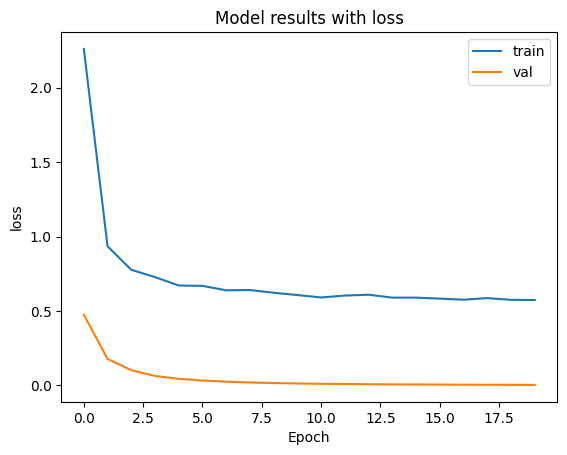

In [20]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

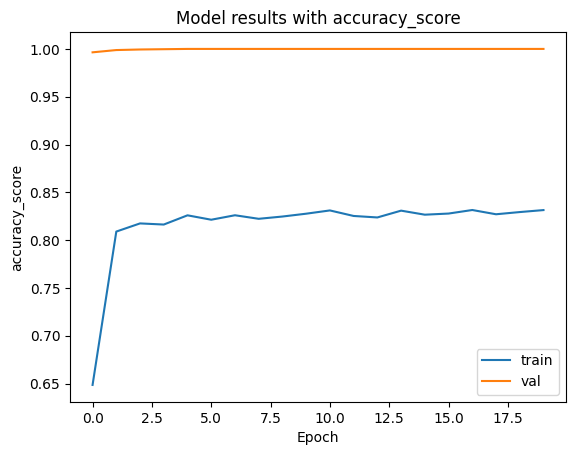

In [21]:
plot_metric(history, 'accuracy_score')

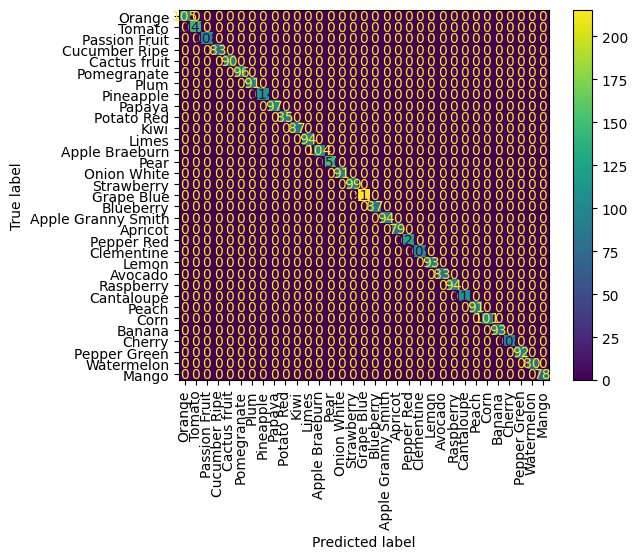

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')
model.eval()

batch_size = 1024 
loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

y_true = []
y_pred = []

for X_batch, y_batch in loader:
    batch_pred = model.predict(X_batch)
    
    y_true.extend(y_batch.tolist())
    y_pred.extend(batch_pred.argmax(-1).tolist())

display_labels = all_classes

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=display_labels)
plt.xticks(rotation=90)
plt.show()